# Analysis of AirBnb Rental Price in Boston and Seattle
1. What are the most important feature for predicting the price of AirBnb?
2. Which city has the higher price?
3. Can you find negative and positive reviews based on text? 
4. which listing has the highest mean price for the two cities? 

In [ ]:
!pip3 install statsmodels

In [143]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_squared_error
from textblob import TextBlob
from sklearn.linear_model import Ridge
import seaborn as sns
from sklearn.linear_model import Lasso
from statsmodels.graphics.gofplots import ProbPlot
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
%matplotlib inline
Boston_listing = pd.read_csv('Boston-listings.csv')
Seattle_listing = pd.read_csv('Seattle-listings.csv')    
Boston_review = pd.read_csv('Boston-reviews.csv')
Seattle_review = pd.read_csv('Seattle-reviews.csv')
Boston_calender = pd.read_csv('Boston-calendar.csv')
Seattle_calender = pd.read_csv('Seattle-calendar.csv')                               

## Question 1: which listing has the highest price at Boston? 

In [2]:
def highest_listing (df):
    '''
    input: listing dataframe of the target city
    output: The description of the listing with the higest price 
    
    '''
    #drop the row with price missing and then grab the array of price(string)
    df_listing_dropna = df.dropna(subset=['price'],axis = 0)
    price = df_listing_dropna['price']
    #change price in dorllar formate to float 
    price = price.str.replace("$",'')
    price = price.str.replace(",","")
    price = price.astype(float)
    #assign the array of price in float formate to the calender dataframe
    df_listing_dropna['price'] = price
    #get the listing_id with highest price
    listing = df_listing_dropna[df_listing_dropna['price'] == price.max()][['name','smart_location','price']]
    name = listing['name'][listing.index[0]]
    location = listing['smart_location'][listing.index[0]]
    the_price = listing['price'][listing.index[0]]                 
                     
    return name,location, the_price
    
    

In [3]:
Boston_name, Boston_location, Boston_price = highest_listing(Boston_listing)
print("The listing with highest price/night in Boston is {} located in {} with the price ${}.".format(Boston_name,Boston_location,Boston_price))

The listing with highest price/night in Boston is Fenway Park/Kenmore Square Flat located in Boston, MA with the price $4000.0.


In [4]:
Seattle_name, Seattle_location, Seattle_price = highest_listing(Seattle_listing)
print("The listing with highest price/night in Seattle is {} located in {} with the price ${}.".format(Seattle_name,Seattle_location,Seattle_price))

The listing with highest price/night in Seattle is Cute Basement Apartment located in Seattle, WA with the price $1000.0.


## Question 2: What the most important features for predicting the price of AirBnb at Boston?

### (1) Data Wrangling 

In [8]:
def DropNa (df):
    '''
    input: Dataframe of listing of target cities
    output:  Dataframes dropping the columns with missing value more than 75%. 
            The  dataframe has the following features:
            1. contain the features only related to price
            2. dummy categorical varialbes
            3. fill na with mean of columns in the numerical varaibles dataframe
            4. drop rows with extremyle higher or lower prices.
            
      
    
    '''
    
    # drop the columns seems uncorrelated to price
    df_drop_features = df.drop(['id','listing_url','name','scrape_id','last_scraped','summary','space','description','calculated_host_listings_count','notes','neighborhood_overview','transit','access','interaction','house_rules','thumbnail_url','medium_url','picture_url','xl_picture_url',
                  'host_id','host_url','host_name','host_location','host_since','host_about','host_thumbnail_url','host_picture_url','city','host_total_listings_count','state','country_code','market','smart_location','country','amenities','calendar_updated','calendar_last_scraped','first_review','last_review','accommodates','availability_60','availability_90'],axis=1)
   
    # drop the rows with price missing 
    df_drop_features_price = df_drop_features.dropna(subset = ['price'])
    #drop columns with missing value more than 75
    n = df_drop_features_price.isnull().sum()/df_drop_features_price.shape[0] < 0.75
    df_drop_features_na = df_drop_features_price[n[n==True].index]
    # change the format of price,weekly price,monthly price, security_deposit,cleaning_fee,extra people from string to float
    dollars = ['price', 'security_deposit','cleaning_fee','extra_people']
    try:
        for dollar in dollars:
            df_drop_features_na[dollar] = df_drop_features_na[dollar].str.replace("$",'').str.replace(",","").astype(float)
    except:
        print("wrong format change")
    # drop the rows with extra bigger or extra smaller price
    drop_price_index = df_drop_features_na[(df_drop_features_na.price > 800) | (df_drop_features_na.price < 100)].index
    df_drop_features_na.drop(drop_price_index,axis = 0, inplace=True)
     #change the format of rate to numeric   
    rates = ['host_response_rate','host_acceptance_rate']
    try:
        for rate in rates:
            df_drop_features_na[rate] = df_drop_features_na[rate].str.replace("%","").astype(float)
            
    except:
        print("wrong percent format change")
        
    num_vars = df_drop_features_na.select_dtypes(include=['float','int']).columns
    cat_vars = df_drop_features_na.select_dtypes(include = ['object']).columns

    # dummy categorical variables
    try:
        
        for cat in cat_vars:
            df_drop_features_na = pd.concat([df_drop_features_na.drop(cat,axis = 1),pd.get_dummies(df_drop_features_na[cat],prefix = cat, prefix_sep = '_', drop_first = True, dummy_na = False)], axis= 1)

    except:
        print("cannot dummy")
  
    # fill in the numerical data frame with mean of each column
    fillmean = lambda col: col.fillna(col.mean())
    try:
        df_drop_features_na = df_drop_features_na.apply(fillmean,axis = 0)
    except:
        print("cannot fill mean")
    
       
    return df_drop_features_na

Boston = DropNa(Boston_listing)

/Users/haijuanzhang/env/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/haijuanzhang/env/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [11]:
# drop columns highly correlated columns

corr = Boston.select_dtypes(include = ['float','int']).corr().abs()
corr[corr > 0.6]
high_corr = ['beds','review_scores_accuracy','review_scores_cleanliness','review_scores_value','review_scores_communication']
Boston_norr = Boston.drop(high_corr,axis = 1)


### (2) Model fitting

#### Randomforest fitting

In [21]:

from scipy.stats import randint
# specify parameters and distributions to sample from
param_dist = {"max_depth": range(2,15,1),
              "n_estimators" : range(80,200,4),
              "min_samples_split": randint(2, 11),
              "bootstrap": [True, False],
              "min_samples_leaf" : randint(1,10)
                            }
n_iter_search = 20

In [18]:
def Randomforest (df):
    #Split into explanatory and response variables
    X = df.drop('price', axis =1 )
    y = df['price']
    # split into training and testing set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    ran_reg = RandomizedSearchCV(RandomForestRegressor(), param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=5,n_jobs=-1)
    ran_reg.fit(X_train,y_train)
   # best_fit = ran_reg.best_estimator_
    y_train_predict = ran_reg.predict(X_train)
    y_test_predict = ran_reg.predict(X_test)
    rtrain_score = r2_score(y_train,y_train_predict)
    rtest_score = r2_score(y_test,y_test_predict)
    return rtest_score, rtrain_score, ran_reg, X_train, X_test, y_train, y_test,X,y
    

In [19]:
rtest_score, rtrain_score, ran_reg, X_train, X_test, y_train, y_test,X,y = Randomforest(Boston_norr)

In [20]:
print("The rsquared on the training data was {}.  The rsquared on the test data was {}.".format(rtrain_score, rtest_score))

The rsquared on the training data was 0.7349907694904455.  The rsquared on the test data was 0.49917764479415205.


#### Gradiant Boosting fitting

In [31]:
  # Grid Search to find Best Parameter
param_grid = {'n_estimators': [300], 
                  'learning_rate': [0.05],
                  'max_depth': [9],
                  'min_samples_split': [5],
                  'subsample': [0.6]
                 }
    
    
def GRAD_BOOSTING (df):
        #Split into explanatory and response variables
    X = df.drop('price', axis =1 )
    y = df['price']
    # split into training and testing set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    GRAD_reg = GridSearchCV(GradientBoostingRegressor(random_state = 42), param_grid, cv=5, scoring = 'neg_mean_squared_error', return_train_score=True)
    GRAD_reg.fit(X_train, y_train)
    y_train_predict = GRAD_reg.predict(X_train)
    y_test_predict = GRAD_reg.predict(X_test)
    GRADtrain_score = r2_score(y_train,y_train_predict)
    GRADtest_score = r2_score(y_test,y_test_predict)
    return GRADtest_score, GRADtrain_score, GRAD_reg, X_train, X_test, y_train, y_test,X,y

    
    

In [32]:
GRADtest_score, GRADtrain_score, GRAD_reg, X_train, X_test, y_train, y_test,X,y = GRAD_BOOSTING(Boston_norr)

In [33]:
print("The rsquared on the training data was {}.  The rsquared on the test data was {}.".format(GRADtrain_score, GRADtest_score))

The rsquared on the training data was 0.9758374417839846.  The rsquared on the test data was 0.5511938465186016.


#### Adaboosting fitting

In [28]:

param_dist = {
 'n_estimators': [500],
 'learning_rate' : [0.05],
  'loss': ['linear']
 }

def ADA_BOOSTING (df):
        #Split into explanatory and response variables
    X = df.drop('price', axis =1 )
    y = df['price']
    # split into training and testing set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    ADA_BOOST = GridSearchCV(AdaBoostRegressor(), param_dist, cv=5, scoring = 'neg_mean_squared_error', return_train_score=True);
    ADA_BOOST.fit(X_train, y_train)
    y_train_predict = ADA_BOOST.predict(X_train)
    y_test_predict = ADA_BOOST.predict(X_test)
    ADAtrain_score = r2_score(y_train,y_train_predict)
    ADAtest_score = r2_score(y_test,y_test_predict)
    return ADAtest_score, ADAtrain_score, ADA_BOOST, X_train, X_test, y_train, y_test,X,y

In [29]:
ADAtest_score, ADAtrain_score, ADA_BOOST, X_train, X_test, y_train, y_test,X,y = ADA_BOOSTING(Boston_norr)

In [30]:
print("The rsquared on the training data was {}.  The rsquared on the test data was {}.".format(ADAtrain_score, ADAtest_score))

The rsquared on the training data was 0.33491407588374345.  The rsquared on the test data was 0.30663279584998315.


#### Since Gradient Boosting method has the higher R-square for test data, so I decide to use Gradient Boosting method to fit model 

Text(0.5, 1.0, 'feature importance for the Top 20 features')

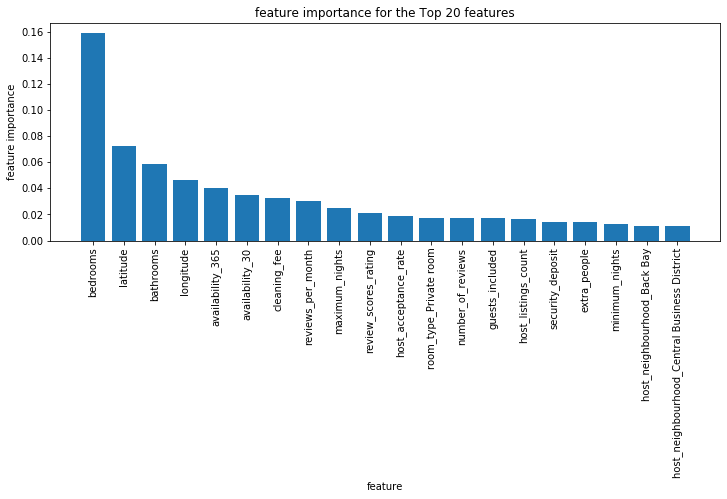

In [39]:
# extract the 20 most important features when predicting price
feature_importances = GRAD_reg.best_estimator_.feature_importances_
features = sorted(zip(feature_importances, Boston_norr.drop(['price'],axis=1).columns), reverse=True)
attribute = []
coefficient = []
for feature in features:
    attribute.append(feature[1]) 
    coefficient.append(feature[0])
plt.figure(figsize=(12,4))
plt.bar(attribute[:20], height=coefficient[:20])
plt.xticks(rotation=90)
plt.xlabel('feature')
plt.ylabel('feature importance')
plt.title('feature importance for the Top 20 features')


## (3) Find positive and negative reviews based on text

In [144]:
Boston_review.dropna(subset= ['comments'],axis=0,inplace=True)
Boston_review.shape

(68222, 6)

In [145]:
reviews = Boston_review['comments'].values

In [146]:
#sentiment = []
opinion = []
for i in list(range(0,len(reviews))):
  #  sentiment.append(TextBlob(reviews[i]).sentiment[0])
    if (TextBlob(reviews[i]).sentiment[0] < 0):
        opinion.append('negative')
    else:
        opinion.append('positive')

In [147]:
Boston_review['opinion'] = opinion

In [148]:
positive_reviews = Boston_review[Boston_review.opinion == 'postive']

In [149]:
netative_reviews = Boston_review[Boston_review.opinion == 'netative']